# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117     #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123     #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# VGGNet + RNN Layers (Time distributed)

# Model-1 
Used VGG16, initialized weights with imagenet.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

#write your model here
#Training VGG model using Transfer Learning

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

58892288/58889256 [==============================] - 5s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
r=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train ; batch size = 32
Epoch 1/10
 Project_data/val ; batch size = 32
21/21 [==============================] - 135s 6s/step - loss: 1.7117 - categorical_accuracy: 0.2038 - val_loss: 1.6216 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2020-12-2501_16_16.746168/model-00001-1.71366-0.20362-1.62156-0.20000.h5
Epoch 2/10
21/21 [==============================] - 33s 2s/step - loss: 1.6695 - categorical_accuracy: 0.2053 - val_loss: 1.6271 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2020-12-2501_16_16.746168/model-00002-1.66906-0.20513-1.62708-0.22000.h5
Epoch 3/10
21/21 [==============================] - 37s 2s/step - loss: 1.6332 - categorical_accuracy: 0.2174 - val_loss: 1.6210 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2020-12-2501_16_16.746168/model-00003-1.63433-0.21569-1.62096-0.23000.h5
Epoch 4/10
21/21 [==============================] - 39s 2s/step

In [12]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [13]:
# plotting Accuracy
plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Model-2 
Increased Epoch to 20 to the same model

In [14]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [15]:
## Print Artifacts ##

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [16]:
## Load the train & val data via generators ##

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [17]:
## Model Saving ##

model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
callbacks_list = [checkpoint, LR]


In [18]:
## Data load ##

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_3 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [20]:
num_epochs = 20
print ('# epochs =', num_epochs)

# epochs = 20


In [21]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 44s 2s/step - loss: 1.8078 - categorical_accuracy: 0.2025 - val_loss: 1.6451 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2501_24_50.496756/model-00001-1.80908-0.20060-1.64510-0.19000.h5
Epoch 2/20
21/21 [==============================] - 34s 2s/step - loss: 1.6411 - categorical_accuracy: 0.2606 - val_loss: 1.5562 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2501_24_50.496756/model-00002-1.63975-0.25943-1.55621-0.30000.h5
Epoch 3/20
21/21 [==============================] - 35s 2s/step - loss: 1.5105 - categorical_accuracy: 0.3430 - val_loss: 1.4647 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2501_24_50.496756/model-00003-1.51124-0.34238-1.46475-0.37000.h5
Epoch 4/20
21/21 [================

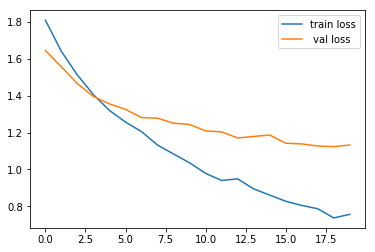

In [22]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

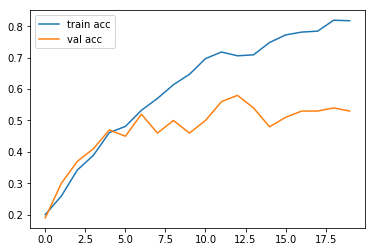

In [23]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

The Model overfits, but lets check by increasing the epoch once more

## Model-3
Increased the Epochs to 30

In [20]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [21]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_5 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [22]:
num_epochs = 30
print ('# epochs =', num_epochs)

# epochs = 30


In [31]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 41s 2s/step - loss: 1.7577 - categorical_accuracy: 0.2220 - val_loss: 1.6364 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2501_36_39.574977/model-00001-1.75620-0.22323-1.63641-0.27000.h5
Epoch 2/30
21/21 [==============================] - 33s 2s/step - loss: 1.6564 - categorical_accuracy: 0.2507 - val_loss: 1.5608 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2501_36_39.574977/model-00002-1.65979-0.24887-1.56076-0.31000.h5
Epoch 3/30
21/21 [==============================] - 32s 2s/step - loss: 1.5351 - categorical_accuracy: 0.3160 - val_loss: 1.5341 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2501_36_39.574977/model-00003-1.53333-0.31674-1.53409-0.34000.h5
Epoch 4/30
21/21 [================

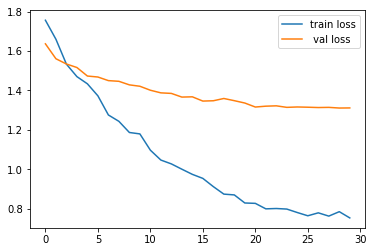

In [32]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

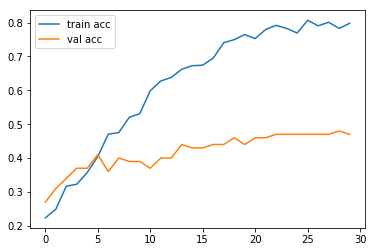

In [33]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Model 4
Changing the LR

In [23]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [24]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [25]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_7 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_8 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [41]:
num_epochs = 30
print ('# epochs =', num_epochs)

# epochs = 30


In [42]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 42s 2s/step - loss: 1.5817 - categorical_accuracy: 0.2903 - val_loss: 1.4049 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00001-1.58420-0.28959-1.40487-0.46000.h5
Epoch 2/30
21/21 [==============================] - 33s 2s/step - loss: 1.3760 - categorical_accuracy: 0.4271 - val_loss: 1.3093 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00002-1.37662-0.42534-1.30934-0.44000.h5
Epoch 3/30
21/21 [==============================] - 36s 2s/step - loss: 1.2077 - categorical_accuracy: 0.4990 - val_loss: 1.1624 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00003-1.20887-0.49925-1.16238-0.52000.h5
Epoch 4/30
21/21 [================

21/21 [==============================] - 35s 2s/step - loss: 0.1978 - categorical_accuracy: 0.9563 - val_loss: 0.6273 - val_categorical_accuracy: 0.7900

Epoch 00028: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00028-0.19791-0.95626-0.62729-0.79000.h5
Epoch 29/30
21/21 [==============================] - 34s 2s/step - loss: 0.1960 - categorical_accuracy: 0.9492 - val_loss: 0.6251 - val_categorical_accuracy: 0.8000

Epoch 00029: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00029-0.19597-0.95023-0.62509-0.80000.h5

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 30/30
21/21 [==============================] - 36s 2s/step - loss: 0.2119 - categorical_accuracy: 0.9429 - val_loss: 0.6279 - val_categorical_accuracy: 0.8000

Epoch 00030: saving model to model_init_conv_lstm_2020-12-2501_53_51.312999/model-00030-0.21203-0.94268-0.62793-0.80000.h5


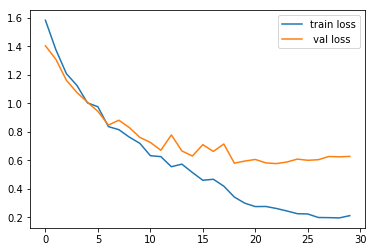

In [43]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

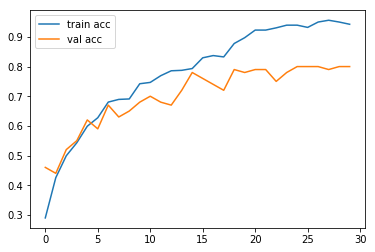

In [44]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Model-5
Playing with decay Rate and learning Rate

In [45]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [50]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [51]:
learning_rate = 0.1
decay_rate = learning_rate / num_epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_9 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_10 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [52]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/trainEpoch 1/30
Project_data/val ; batch size = 32
 ; batch size = 32
21/21 [==============================] - 42s 2s/step - loss: 1.7009 - categorical_accuracy: 0.1714 - val_loss: 1.6067 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00001-1.70109-0.17195-1.60668-0.21000.h5
Epoch 2/30
21/21 [==============================] - 33s 2s/step - loss: 1.6329 - categorical_accuracy: 0.2133 - val_loss: 1.6267 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00002-1.63331-0.21267-1.62671-0.21000.h5
Epoch 3/30
21/21 [==============================] - 35s 2s/step - loss: 1.6251 - categorical_accuracy: 0.1829 - val_loss: 1.6038 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00003-1.62527-0.18250-1.60384-0.23000.h5
Epoch 4/30
21/21 [================

21/21 [==============================] - 35s 2s/step - loss: 1.6087 - categorical_accuracy: 0.2204 - val_loss: 1.6069 - val_categorical_accuracy: 0.2100

Epoch 00026: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00026-1.60892-0.21870-1.60687-0.21000.h5
Epoch 27/30
21/21 [==============================] - 34s 2s/step - loss: 1.6107 - categorical_accuracy: 0.1954 - val_loss: 1.6069 - val_categorical_accuracy: 0.2100

Epoch 00027: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00027-1.61075-0.19457-1.60687-0.21000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.441406286379788e-05.
Epoch 28/30
21/21 [==============================] - 36s 2s/step - loss: 1.6115 - categorical_accuracy: 0.2172 - val_loss: 1.6069 - val_categorical_accuracy: 0.2100

Epoch 00028: saving model to model_init_conv_lstm_2020-12-2502_11_50.595994/model-00028-1.61167-0.21719-1.60687-0.21000.h5
Epoch 29/30
21/21 [==============================] - 35s 2s/step

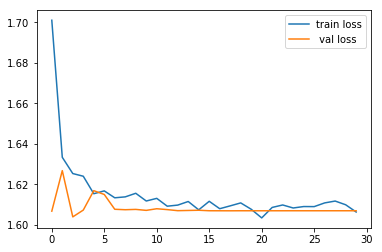

In [53]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

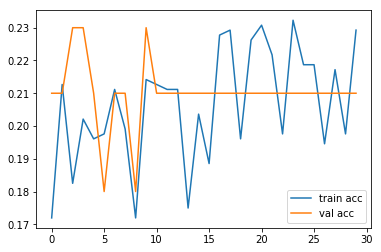

In [54]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Model-6
Using more epoch of 50 in the same model as above

In [55]:
## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [60]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [61]:
#Model Compilation 
learning_rate = 0.01
decay_rate = learning_rate / num_epochs
momentum = 0.8
sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_11 (GRU)                 (None, 15, 32)            9312      
_________________________________________________________________
gru_12 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [62]:
num_epochs = 50

In [63]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 44s 2s/step - loss: 1.6099 - categorical_accuracy: 0.2829 - val_loss: 1.4797 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2502_29_33.923267/model-00001-1.61109-0.28205-1.47974-0.49000.h5
Epoch 2/50
21/21 [==============================] - 35s 2s/step - loss: 1.5126 - categorical_accuracy: 0.3395 - val_loss: 1.4552 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2502_29_33.923267/model-00002-1.51301-0.33937-1.45519-0.47000.h5
Epoch 3/50
21/21 [==============================] - 36s 2s/step - loss: 1.4172 - categorical_accuracy: 0.4415 - val_loss: 1.3092 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2502_29_33.923267/model-00003-1.41893-0.44042-1.30922-0.53000.h5
Epoch 4/50
21/21 [================

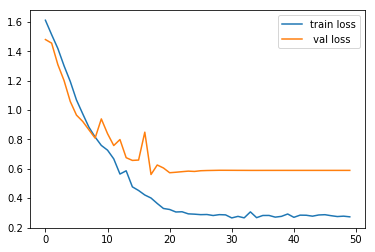

In [64]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

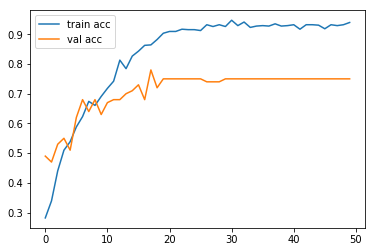

In [65]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Model- 7
Using Adam as the optimizer

In [66]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16


## Starter Code ##
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,24,26,28]
    #img_idx = [x for x in range(0,30)]
    while True:
        t = np.random.permutation(folder_list)
        #if ablation is not None:
         #   t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [71]:
## Model ##
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='elu'))
model.add(Dense(5, activation='softmax'))

In [72]:
optimiser = optimizers.Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 15, 64)            15009664  
_________________________________________________________________
gru_13 (GRU)                 (None, 15, 32)            9312      
_________________________________________________________________
gru_14 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 45        
Total params: 15,021,509
Trainable params: 306,821
Non-trainable params: 14,714,688
__________________________________________________________

In [73]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 40s 2s/step - loss: 1.5679 - categorical_accuracy: 0.3011 - val_loss: 1.3415 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_conv_lstm_2020-12-2502_59_14.361280/model-00001-1.56780-0.30166-1.34153-0.53000.h5
Epoch 2/30
21/21 [==============================] - 32s 2s/step - loss: 1.3413 - categorical_accuracy: 0.4420 - val_loss: 1.2572 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_conv_lstm_2020-12-2502_59_14.361280/model-00002-1.34357-0.44042-1.25715-0.49000.h5
Epoch 3/30
21/21 [==============================] - 32s 2s/step - loss: 1.2191 - categorical_accuracy: 0.4914 - val_loss: 1.1711 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_conv_lstm_2020-12-2502_59_14.361280/model-00003-1.21616-0.49321-1.17114-0.56000.h5
Epoch 4/30
21/21 [================

RuntimeError: Problems closing file (file write failed: time = Fri Dec 25 03:13:10 2020
, filename = 'model_init_conv_lstm_2020-12-2502_59_14.361280/model-00024-0.18298-0.96983-0.65894-0.77000.h5', file descriptor = 66, errno = 28, error message = 'No space left on device', buf = 0x5629aa7b3030, total write size = 11968, bytes this sub-write = 11968, bytes actually written = 18446744073709551615, offset = 4096)

In [1]:
#plot the loss
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

NameError: name 'r' is not defined

In [2]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

NameError: name 'r' is not defined

## Model Conv3d networks
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

NameError: name 'np' is not defined

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error

In [ ]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 64
ablation=100

In [ ]:
train_doc.shape

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

New generator with ablation and Validation parameter

In [ ]:
def generator(source_path, folder_list, batch_size, ablation=None,Validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    #img_idx = [x for x in range(0, 30)] 
    while True:
        t = np.random.permutation(folder_list)
        if ablation is not None and Validation==False:
                t = t[:ablation]
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = imresize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Creating conv3d with relu activation and softmax as output activation for 5 classes. 4 filters nb_filters = 8,16,32,64

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

nb_filters = [8,16,32,64]
nb_dense = [128, 5]

# Input
input_shape=(15,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[1], activation='softmax'))


In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
ablation=64
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
print(steps_per_epoch)
print(validation_steps)

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size,ablation=None,Validation=True)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Ablation run for 1st conv3d model with ablation size 64 and 10 epochs

In [ ]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

Increasing the number of epochs to 30 for same ablation size

In [ ]:
num_epochs = 30
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 2
Executing for all 663 traing videos i.e., 66315 images 3 for RGB

Epoch 10

In [ ]:
ablation=len(train_doc)
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
print(steps_per_epoch)
print(validation_steps)

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,ablation=ablation)
val_generator = generator(val_path, val_doc, batch_size,ablation=None,Validation=True)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Used 3 workers to execute model

In [ ]:
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

As the model is still underfitting and accuracy is very low, increasing epochs to increase training of weights

In [ ]:
#trying with 50 epochs
num_epochs = 50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 3

In [ ]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 4

In [ ]:
num_epochs=50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 5
Seems like model is not able to train upto the mark. Addidng data Augmentation to improve training.

In [ ]:
import cv2
# Parameters initialization
nb_rows = 120   # X dimension of the image
nb_cols = 120   # Y dimesnion of the image
#total_frames = 30
nb_frames = 30  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray

Creating new generator to add augmented data by adding data and taking all 30 fromes for training.

In [ ]:
def data_processing(source_path, folder_list, batch_num, batch_size, t,validation):
    
    batch_data = batch_data_aug = batch_data_flip = np.zeros((batch_size, nb_frames, 120, 120, 3)) 
    batch_labels = batch_labels_aug = batch_labels_flip = np.zeros((batch_size,5))
    
    
    img_idx = [x for x in range(0, nb_frames)] 

    for folder in range(batch_size):
        
        imgs = os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])
        
        # Generate a random affine to be used in image transformation for buidling agumented data set
        dx, dy = np.random.randint(-1, 1, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        
        for idx, item in enumerate(img_idx): 
            image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            if image.shape[1] == 160:
                image = image[:,20:140,:].astype(np.float32)
            else:
                image = imresize(image,(120,120)).astype(np.float32)
            
            resized = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
            batch_data[folder,idx] = (resized)
            
            #Affine transformation
            batch_data_aug[folder,idx] = (cv2.warpAffine(resized, M, (resized.shape[0], resized.shape[1])))
            
            #Horizontal flip
            batch_data_flip[folder,idx]= np.flip(resized,1)

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        # Labeling data with horizobtal flip, right swipe becomes left swipe and viceversa
        if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
        elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                    
        else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
                  
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)
    batch_data_final = np.append(batch_data_final, batch_data_flip, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 
    batch_labels_final = np.append(batch_labels_final, batch_labels_flip, axis = 0)
    
    if validation:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
        
    return batch_data_final,batch_labels_final

In [ ]:
def generator(source_path, folder_list, batch_size, validation=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size 
        for batch in range(num_batches): 
            yield data_processing(source_path, folder_list, batch, batch_size, t,validation)
    
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield data_processing(source_path, folder_list, batch, batch_size, t,validation)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='relu'))

model.add(Dense(nb_dense[1], activation='relu'))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))


In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
ablation=len(train_doc)
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
batch_size=20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = ablation
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

In [ ]:
print(steps_per_epoch)
print(validation_steps)

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size,validation=True)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

Trying with 20 epoch

In [ ]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 6

In [ ]:
num_epochs=20
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
plt.plot(r.history['loss'], label = 'train loss' )
plt.plot(r.history['val_loss'], label = ' val loss')
plt.legend()
plt.show()

In [ ]:
#plot the accuracy

plt.plot(r.history['categorical_accuracy'], label='train acc')
plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
plt.legend()
plt.show()

## Experiment 7
Tried elu activation instead of relu

In [ ]:
#Trail Model can be deleted
# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('elu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='elu'))
#model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
num_epochs=50
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
num_epochs=200
r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

## Experiment 8
Trying swish activation instead of relu

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [ ]:

class swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

In [ ]:
#Trail Model can be deleted
# Input
input_shape=(30,120,120,3)

nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]
# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))

model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(Activation('swish'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(nb_dense[0], activation='swish'))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='swish'))
#model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
#Not working giving error at the end of 1st epoch
#AttributeError: 'Activation' object has no attribute '__name__'



#num_epochs=5
#r = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=3, initial_epoch=0)

In [ ]:
#plot the loss
#plt.plot(r.history['loss'], label = 'train loss' )
#plt.plot(r.history['val_loss'], label = ' val loss')
#plt.legend()
#plt.show()

In [ ]:
#plot the accuracy

#plt.plot(r.history['categorical_accuracy'], label='train acc')
#plt.plot(r.history['val_categorical_accuracy'], label = 'val acc')
#plt.legend()
#plt.show()